# [Part 1] Imports and setting up directory structure

In [0]:
import requests
import urllib
import json
import matplotlib.pyplot as plt
import warnings
import time
import numpy as np
import os.path
from os import path
from sklearn.metrics import mean_squared_error

!pip install statsmodels==0.11.1
from statsmodels.tsa.arima.model import ARIMA

     |████████████████████████████████| 8.7MB 3.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [0]:
cd drive/My\ Drive/Pennovation/COVID19-Unemployment

/content/drive/My Drive/Pennovation/COVID19-Unemployment


# [Part 2] Load data

- Dotcom Bubble (1995 – 2001)
- Great Recession (December 2007 – June 2009)


In [0]:
area_dict = {}

if path.exists('dataset/area.txt'):
    f = open('dataset/area.txt', mode='r')
    lines = f.readlines()
    for line in lines[1:]:
        split_line = line.split('\t')
        area_dict[split_line[2]] = split_line[1]
    f.close()
else: 
    url = "https://download.bls.gov/pub/time.series/la/la.area"
    file = urllib.request.urlopen(url)
    for line in file:
        decoded_line = line.decode("utf-8")
        split_line = decoded_line.split('\t')
        area_dict[split_line[2]] = split_line[1]

state_names = []
for area_text, area_code in area_dict.items():
    if area_code[:2] == 'ST' and area_text != 'Puerto Rico':
        state_names.append(area_text)

area_dict

{'Alabama': 'ST0100000000000',
 'Alaska': 'ST0200000000000',
 'Arizona': 'ST0400000000000',
 'Arkansas': 'ST0500000000000',
 'California': 'ST0600000000000',
 'Colorado': 'ST0800000000000',
 'Connecticut': 'ST0900000000000',
 'Delaware': 'ST1000000000000',
 'District of Columbia': 'CN1100100000000',
 'Florida': 'ST1200000000000',
 'Georgia': 'ST1300000000000',
 'Hawaii': 'ST1500000000000',
 'Idaho': 'ST1600000000000',
 'Illinois': 'ST1700000000000',
 'Indiana': 'ST1800000000000',
 'Iowa': 'ST1900000000000',
 'Kansas': 'ST2000000000000',
 'Kentucky': 'ST2100000000000',
 'Louisiana': 'ST2200000000000',
 'Maine': 'ST2300000000000',
 'Maryland': 'ST2400000000000',
 'Massachusetts': 'ST2500000000000',
 'Michigan': 'ST2600000000000',
 'Minnesota': 'ST2700000000000',
 'Mississippi': 'ST2800000000000',
 'Missouri': 'ST2900000000000',
 'Montana': 'ST3000000000000',
 'Nebraska': 'ST3100000000000',
 'Nevada': 'ST3200000000000',
 'New Hampshire': 'ST3300000000000',
 'New Jersey': 'ST3400000000000'

In [0]:
def visualize_timeseries(timeseries):
    t, l, s = [], [], []
    for i, item in enumerate(timeseries):
        t.append(i)
        l.append(item[0])
        s.append(item[1])

    plt.rcParams['figure.figsize'] = [200, 50]
    plt.rcParams['font.size'] =  30
    plt.rcParams['lines.linewidth'] = 10
    plt.plot(t,s)
    plt.xticks(t, l, rotation='vertical')
    plt.title(area_text)
    plt.show()


def get_timeseries(area_text='Pennsylvania', visualize=False, data_range=(1990,2020), season_adjust='S', data_type='03'):
    # LA: prefix
    # S: Seasonally adjusted
    # ST4200000000000: Pennsylvania area_code 
    # 03: Unemployment rate data_type (05 Employment)

    area_code = area_dict[area_text]
    series_id = 'LA' + season_adjust + area_code + data_type
    
    headers = {'Content-type': 'application/json'}
    timeseries = []
    
    for start in range(data_range[0], data_range[1]+1, 10):
        data = json.dumps({"seriesid": [series_id],"startyear":str(start), "endyear":str(min(start+9, data_range[1]))})
        p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
        json_data = json.loads(p.text)
        
        if json_data['status'] != 'REQUEST_SUCCEEDED':
            print('Failed')
            print(json_data['message'])
            return []
        
        else:
            sub_ts = []
            for series in json_data['Results']['series']:
                seriesId = series['seriesID']
                for item in series['data']:
                    year = item['year']
                    period = item['period']
                    value = item['value']
                    sub_ts.append((period+" "+year, float(value)))
            timeseries += sub_ts[::-1]

    if visualize and timeseries:
        visualize_timeseries(timeseries)

    return timeseries


def load_data():
    state_data = {} 
    txt_files = os.listdir('dataset/state')
    for txt_file in sorted(txt_files): 
        if txt_file[-3:] == 'txt':
            ts = []
            print(txt_file[:-4] + ' data already exists... ', end='', flush=True)
            with open('dataset/state/'+txt_file, 'r') as f:
                for line in f:
                    split_line = line.split(',')
                    ts.append((split_line[0][1:-1], float(split_line[1])))
            state_data[txt_file[:-4]] = ts
            print('Loaded')
        
    for area_text in state_names:
        if area_text not in state_data:
            print('Requesting for ' + area_text + ' data... ', end='', flush=True)
            ts = get_timeseries(area_text=area_text)
            if ts:
                state_data[area_text] = ts
                with open('dataset/state/'+area_text+'.txt', 'w') as f:
                    for i in state_data[area_text]:
                        f.write('%s\n' % str(i)[1:-1])
                print('Saved/Loaded')
            else: 
                break;
    
    print('Available data: ', list(state_data.keys()))
    return state_data


def data_update(ts, curr_year, area_text, season_adjust='S', data_type='03'):
    series_id = 'LA' + season_adjust + area_dict[area_text] + data_type
    headers = {'Content-type': 'application/json'}

    data_last_month = int(ts[-1][0][:3][1:])
    data_last_year = int(ts[-1][0][-4:])

    curr_data_last_year = data_last_year

    while curr_data_last_year <= curr_year: 
        data = json.dumps({"seriesid": [series_id],"startyear":str(curr_data_last_year), "endyear":str(min(curr_data_last_year+9, curr_year))})
        p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
        json_data = json.loads(p.text)

        if json_data['status'] != 'REQUEST_SUCCEEDED':
            print('Data update failed')
            print(json_data['message'])
            return ts

        else: 
            most_recent = json_data['Results']['series'][0]['data'][0]
            if int(most_recent['period'][1:]) == data_last_month and int(most_recent['year']) == data_last_year:
                print('Data is already up-to-date')
                return ts
            
            else:
                for item in json_data['Results']['series'][0]['data'][::-1]:
                    year = int(item['year'])
                    period = int(item['period'][1:])
                    if (year > data_last_year) or (year == data_last_year and period > data_last_month): 
                        ts.append((item['period']+" "+item['year'], float(item['value'])))
                        with open('dataset/state/'+area_text+'.txt', 'a') as f:
                            f.write('%s\n' % str(ts[-1])[1:-1])

        curr_data_last_year += 10
    
    print('Data update completed')
    return ts

In [0]:
state_data = load_data()

Alabama data already exists... Loaded
Alaska data already exists... Loaded
Arizona data already exists... Loaded
Arkansas data already exists... Loaded
California data already exists... Loaded
Colorado data already exists... Loaded
Connecticut data already exists... Loaded
Delaware data already exists... Loaded
Florida data already exists... Loaded
Georgia data already exists... Loaded
Hawaii data already exists... Loaded
Idaho data already exists... Loaded
Illinois data already exists... Loaded
Indiana data already exists... Loaded
Iowa data already exists... Loaded
Kansas data already exists... Loaded
Kentucky data already exists... Loaded
Louisiana data already exists... Loaded
Maine data already exists... Loaded
Maryland data already exists... Loaded
Massachusetts data already exists... Loaded
Michigan data already exists... Loaded
Minnesota data already exists... Loaded
Mississippi data already exists... Loaded
Missouri data already exists... Loaded
Montana data already exists... 

# [Part 3] Model

In [0]:
def create_future_labels(l, future_steps=48):
    prev_month = int(l[-1][1:3])
    year = int(l[-1][4:])

    l2 = []

    for s in range(future_steps):
        if prev_month == 12:
            curr_month = 1
            year += 1
        else: curr_month=prev_month+1

        ms = str(curr_month)
        if len(ms) == 1: l2.append("M0" + ms + " " + str(year))
        else: l2.append("M" + ms + " " + str(year))

        prev_month = curr_month
    
    return l2


def evaluate_model(timeseries, order): # order = (p,d,q)
    data = [i[1] for i in timeseries]
    
    train_size = int(len(data) * 0.63)
    validation_size = int(len(data) * 0.17)
    train, validation, test = data[0:train_size], data[train_size:train_size+validation_size], data[train_size+validation_size:]
    
    history = [x for x in train]
    predictions = []
    for t in range(len(validation)):
        model = ARIMA(history, order=order, enforce_stationarity=False)
        
        try:
            model_fit = model.fit()
        except Exception as e:
            print('Validation ' + str(e))
            return float('inf'), float('inf')
        
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(validation[t])
    
    try: 
        validation_error = mean_squared_error(validation, predictions)
    except Exception as e:
        return float('inf'), float('inf')
    
    history = [x for x in train + validation]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=order, enforce_stationarity=False)
        
        try:
            model_fit = model.fit()
        except Exception as e: 
            print('Test ' + str(e))
            return float('inf'), float('inf')
        
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    try:
        test_error = mean_squared_error(test, predictions)
    except Exception as e:
        return validation_error, float('inf')
    
    return validation_error, test_error

    
def forecast(timeseries, area_text='Pennsylvania', order=(9,0,2), future_steps=48): 
    data = [i[1] for i in timeseries]
    model = ARIMA(data, order=order, enforce_stationarity=False) 
    model_fit = model.fit()

    yhat = model_fit.predict(0, len(data)-1, typ='levels') 
    t, l, s = [], [], []
    for i, item in enumerate(timeseries):
        t.append(i)
        l.append(item[0])
        s.append(float(item[1]))
    
    yhat2 = model_fit.predict(len(data),len(data)+(future_steps-1), typ='levels')
    t2 = t + list(range(t[-1]+1, t[-1]+future_steps+1))
    l2 = create_future_labels(l, future_steps)
    
    print('Maximum unemployment rate %.2f at %s' % (np.max(yhat2), l2[np.argmax(yhat2)]))

    plt.rcParams['figure.figsize'] = [200, 50]
    plt.rcParams['font.size'] =  30
    plt.rcParams['lines.linewidth'] = 10
    plt.rcParams['legend.fontsize'] = 50
    plt.rcParams['legend.handlelength'] = 10
    
    fig = plt.figure()

    plt.plot(t,s,label='history')
    plt.plot(t[5:],yhat[5:],label='fit')
    plt.plot(t2[len(yhat)-1:],[yhat[-1]]+list(yhat2), color='red', label='forecast')
    plt.xticks(t2, l+l2, rotation='vertical')
    plt.legend()
    plt.title(area_text + ' ' + str(order))
    fig.savefig('results/'+area_text + '_' + str(order) + '_forecast.png', dpi=fig.dpi)
    plt.show()


def check_forecast(ts, area_text, train_years, order, future_steps, plot_residuals=False):
    fraction = [t for t in ts if int(t[0][-4:]) in train_years]

    data = [i[1] for i in fraction]
    model = ARIMA(data, order=order, enforce_stationarity=False) 
    model_fit = model.fit()

    yhat = model_fit.predict(0, len(data)-1, typ='levels') 
    t, l, s = [], [], []
    for i, item in enumerate(fraction):
        t.append(i)
        l.append(item[0])
        s.append(float(item[1]))

    yhat2 = model_fit.predict(len(data),len(data)+(future_steps-1), typ='levels')
    t2 = t + list(range(t[-1]+1, t[-1]+future_steps+1))
    l2 = l + create_future_labels(l, future_steps)

    plt.rcParams['figure.figsize'] = [200, 50]
    plt.rcParams['font.size'] =  30
    plt.rcParams['lines.linewidth'] = 10
    plt.rcParams['legend.fontsize'] = 50
    plt.rcParams['legend.handlelength'] = 10

    total_years = list(range(train_years[0],int(train_years[-1]+(future_steps/12))+1))
    plt.plot(t2, [float(t[1]) for t in ts if int(t[0][-4:]) in total_years], label='history')
    plt.plot(t2[len(yhat)-1:],[yhat[-1]]+list(yhat2), color='red', label='forecast')
    plt.xticks(t2, l2, rotation='vertical')
    plt.legend()
    plt.title("Check forecast: " + area_text + " " + str(order))
    plt.show()

    if plot_residuals: 
        plt.rcParams['figure.figsize'] = [5, 2.5]
        plt.rcParams['font.size'] =  4
        plt.rcParams['lines.linewidth'] = 0.5
        plt.rcParams['legend.fontsize'] = 5
        plt.rcParams['legend.handlelength'] = 1

        test_years = list(range(train_years[-1]+1,int(train_years[-1]+(future_steps/12))+1))
        y2 = [float(t[1]) for t in ts if int(t[0][-4:]) in test_years]
        plt.plot(t2[-future_steps:], [abs(t) for t in y2-yhat2],label='residual',color='orange')
        plt.xticks(t2[-future_steps:], l2[-future_steps:], rotation='vertical')
        plt.legend()
        plt.title(area_text + " " + str(order))
        plt.show()


def grid_search(ts):
    start_time = time.time()

    p_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    d_values = range(0, 3)
    q_values = range(0, 4)
    
    warnings.filterwarnings("ignore")

    results = {} 

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                validation_mse, test_mse = evaluate_model(ts, order)
                
                if validation_mse != float('inf') and test_mse != float('inf'):
                    results[order] = (validation_mse,test_mse)
                
                print('ARIMA%s \t Validation MSE=%.3f \t Test MSE=%.3f' % (order, validation_mse, test_mse))
    
    print('Grid search completed. Time elapsed %.2f seconds' % (time.time() - start_time))
    
    results = sorted(results.items(), key=lambda item: item[1])

    v_mses = [item[1][0] for item in results]
    t_mses = [item[1][1] for item in results]
    indices = [i for i, v_mse in enumerate(v_mses) if v_mse < 1]
    
    # plt.style.use('default')
    plt.rcParams['figure.figsize'] = [4, 3.5]
    plt.rcParams['font.size'] =  10
    plt.rcParams['lines.linewidth'] = 0.5
    plt.rcParams['legend.fontsize'] = 4
    plt.rcParams['legend.handlelength'] = 1

    plt.scatter([v_mse for i, v_mse in enumerate(v_mses) if i in indices], [t_mse for i, t_mse in enumerate(t_mses) if i in indices])
    plt.xlabel('validation mse')
    plt.ylabel('test mse')
    plt.show()
    
    print('Best model: ARIMA%s \t Validation_MSE=%.3f \t Test MSE=%.3f' % (results[0][0], results[0][1][0], results[0][1][1]))
    return results

# [Part 4] Run

In [0]:
area_text = "" # STATE NAME
curr_year = 2020 # CURRENT YEAR

ts = data_update(state_data[area_text], curr_year, area_text)
results = grid_search(ts) 

for i in range(3):
    print('ARIMA%s \t Validation MSE=%.3f \t Test MSE=%.3f' % (results[i][0], results[i][1][0], results[i][1][1]))
    forecast(ts, area_text, order=results[i][0], future_steps=12*5)
    check_forecast(ts, area_text, list(range(1990,2009)), order=results[i][0], future_steps=12*5)

# [Part 5] Sample: Pennsylvania

ARIMA(0, 0, 0) 	 Validation MSE=4.926 	 Test MSE=1.129
ARIMA(0, 0, 1) 	 Validation MSE=1.315 	 Test MSE=0.323
ARIMA(0, 0, 2) 	 Validation MSE=0.396 	 Test MSE=0.134
ARIMA(0, 0, 3) 	 Validation MSE=0.193 	 Test MSE=0.071
ARIMA(0, 1, 0) 	 Validation MSE=0.016 	 Test MSE=0.028
ARIMA(0, 1, 1) 	 Validation MSE=0.010 	 Test MSE=0.028
ARIMA(0, 1, 2) 	 Validation MSE=0.007 	 Test MSE=0.026
ARIMA(0, 1, 3) 	 Validation MSE=0.006 	 Test MSE=0.024
ARIMA(0, 2, 0) 	 Validation MSE=0.007 	 Test MSE=0.028
ARIMA(0, 2, 1) 	 Validation MSE=0.006 	 Test MSE=0.025
ARIMA(0, 2, 2) 	 Validation MSE=0.005 	 Test MSE=0.024
ARIMA(0, 2, 3) 	 Validation MSE=0.005 	 Test MSE=0.024
ARIMA(1, 0, 0) 	 Validation MSE=0.016 	 Test MSE=0.028
ARIMA(1, 0, 1) 	 Validation MSE=0.011 	 Test MSE=0.028
ARIMA(1, 0, 2) 	 Validation MSE=0.007 	 Test MSE=0.026
ARIMA(1, 0, 3) 	 Validation MSE=0.006 	 Test MSE=0.024
ARIMA(1, 1, 0) 	 Validation MSE=0.006 	 Test MSE=0.027
ARIMA(1, 1, 1) 	 Validation MSE=0.005 	 Test MSE=0.025
ARIMA(1, 1

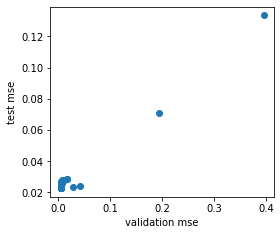

Best model: ARIMA(4, 1, 2) 	 Validation_MSE=0.004 	 Test MSE=0.024

[1] ARIMA(4, 1, 2) 	 Validation MSE=0.004 	 Test MSE=0.024
Maximum unemployment rate 11.41 at M03 2025


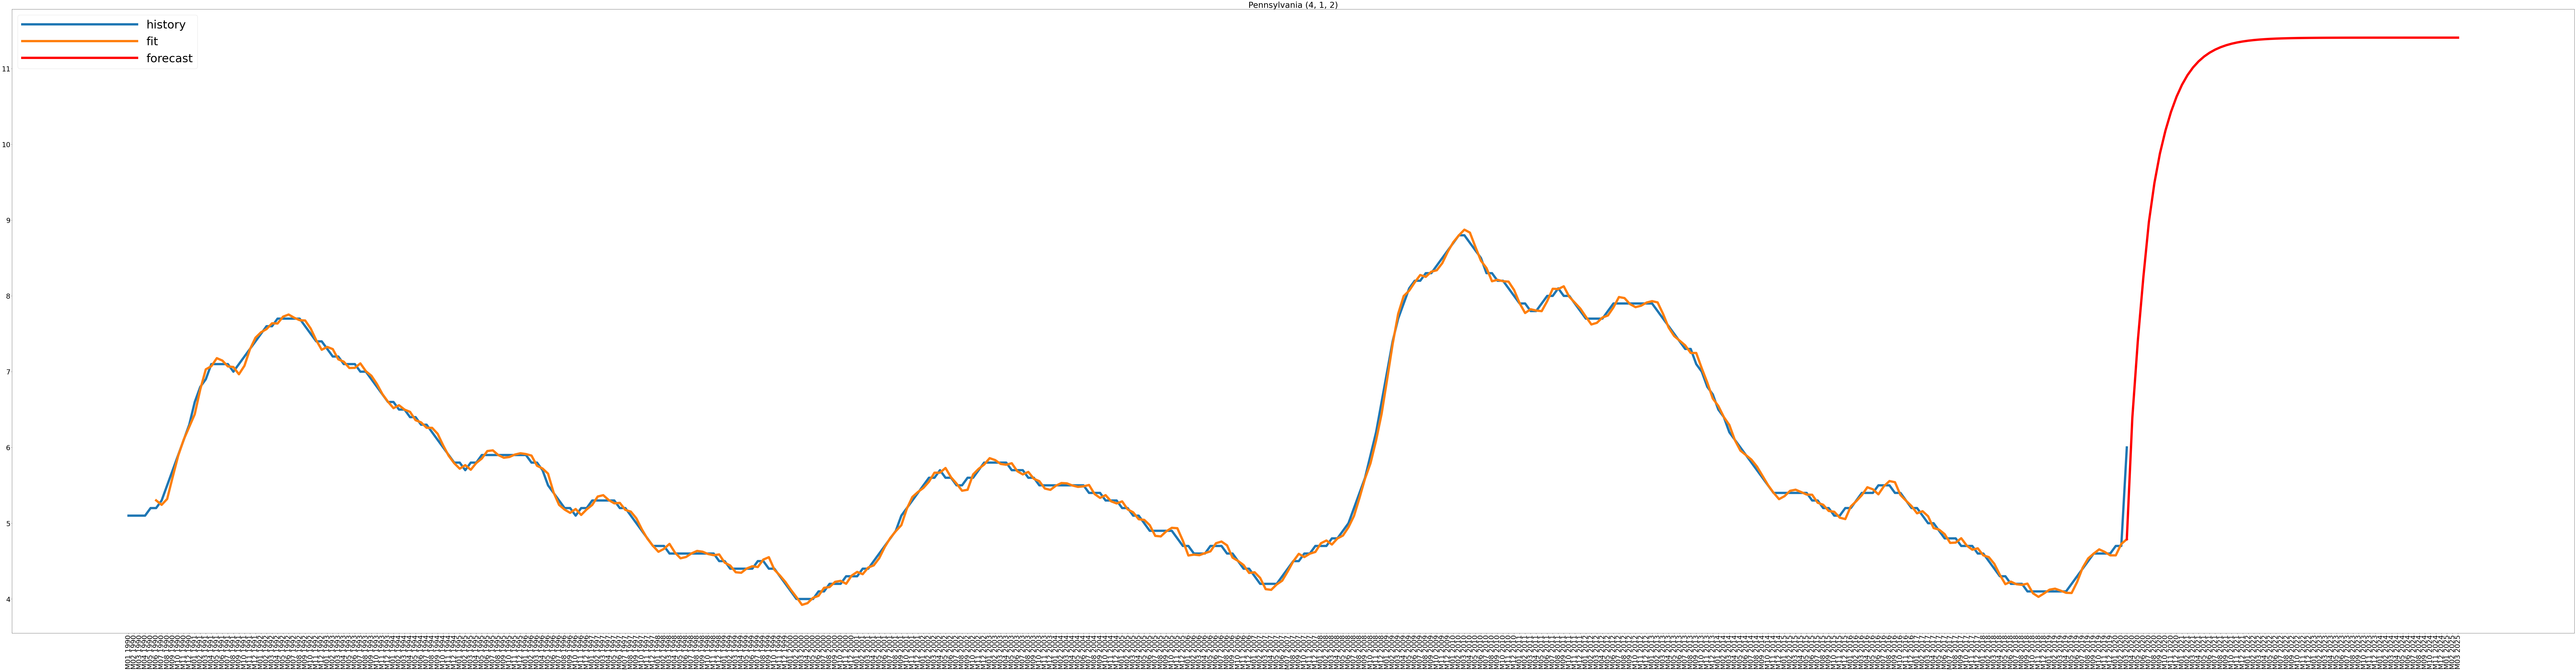

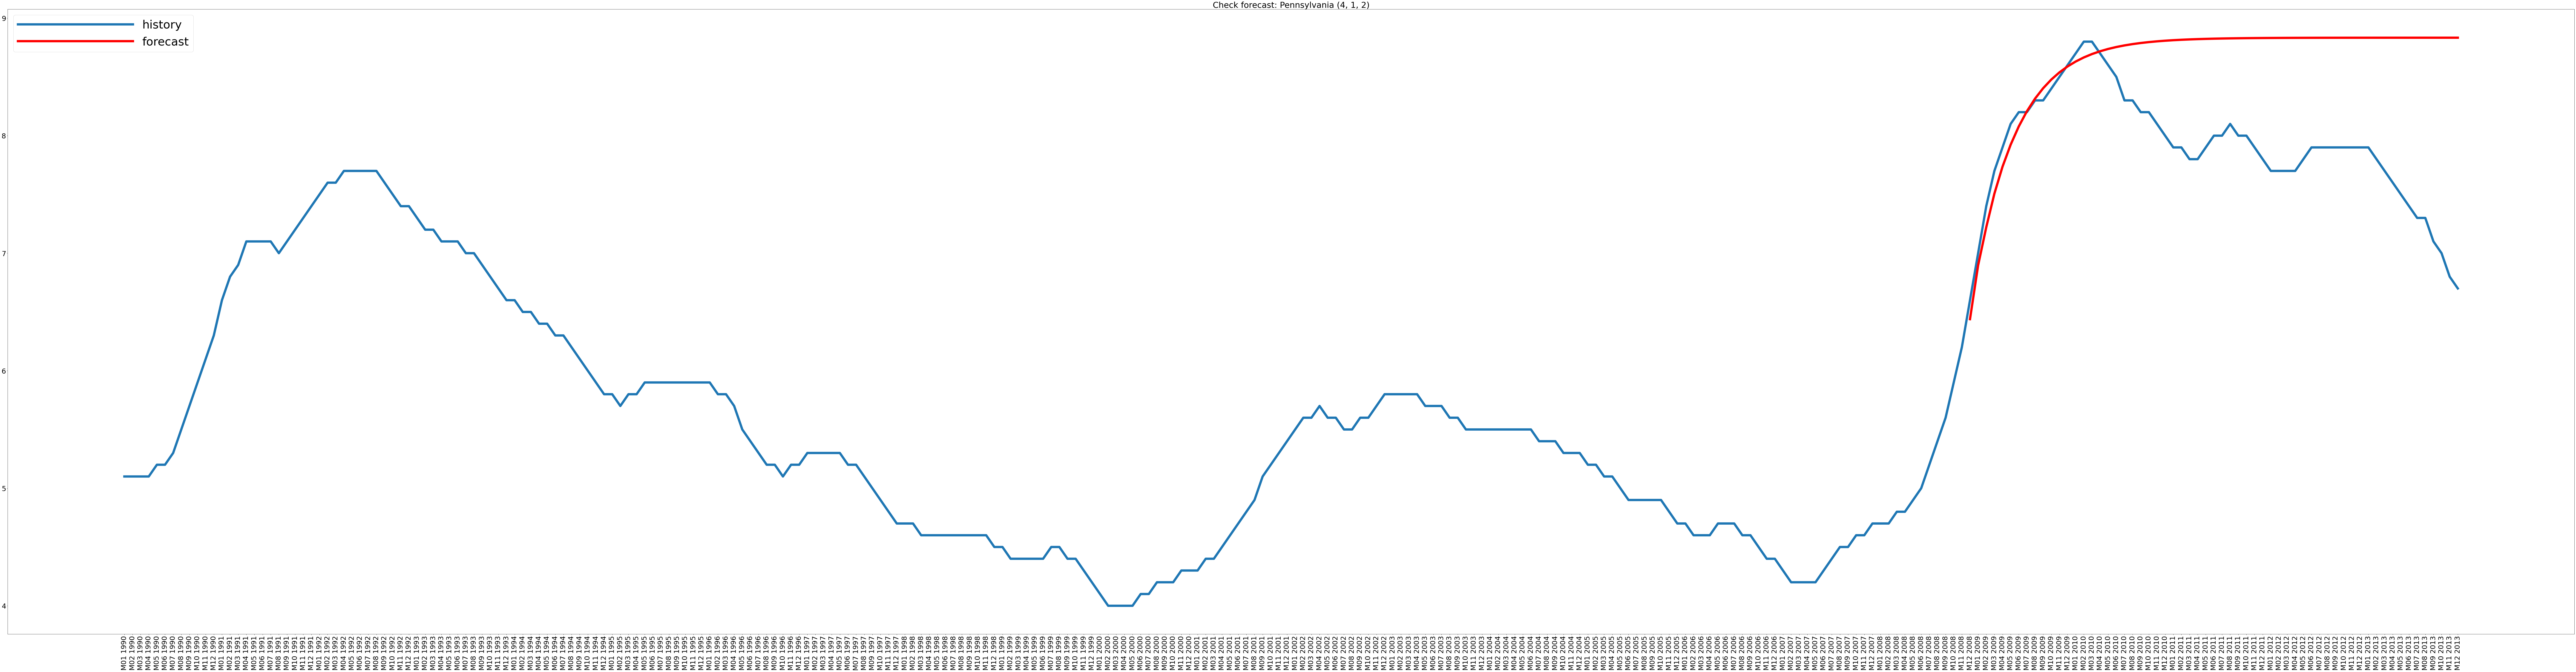


[2] ARIMA(4, 1, 3) 	 Validation MSE=0.004 	 Test MSE=0.024
Maximum unemployment rate 11.25 at M11 2023


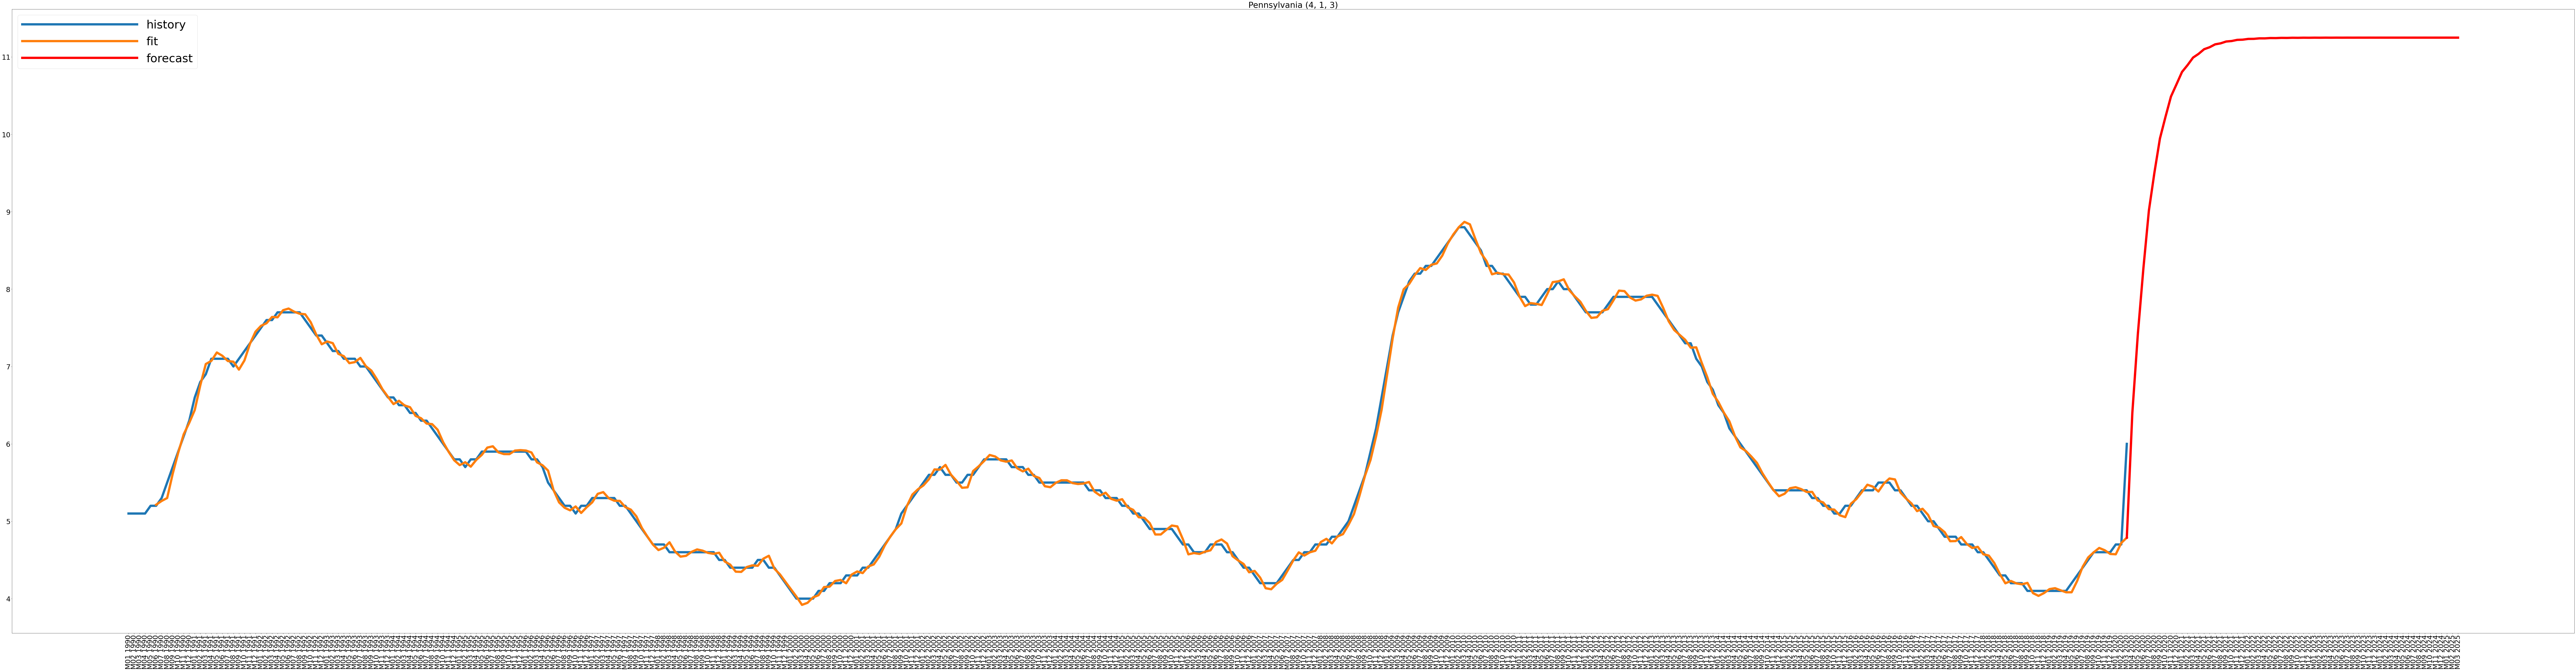

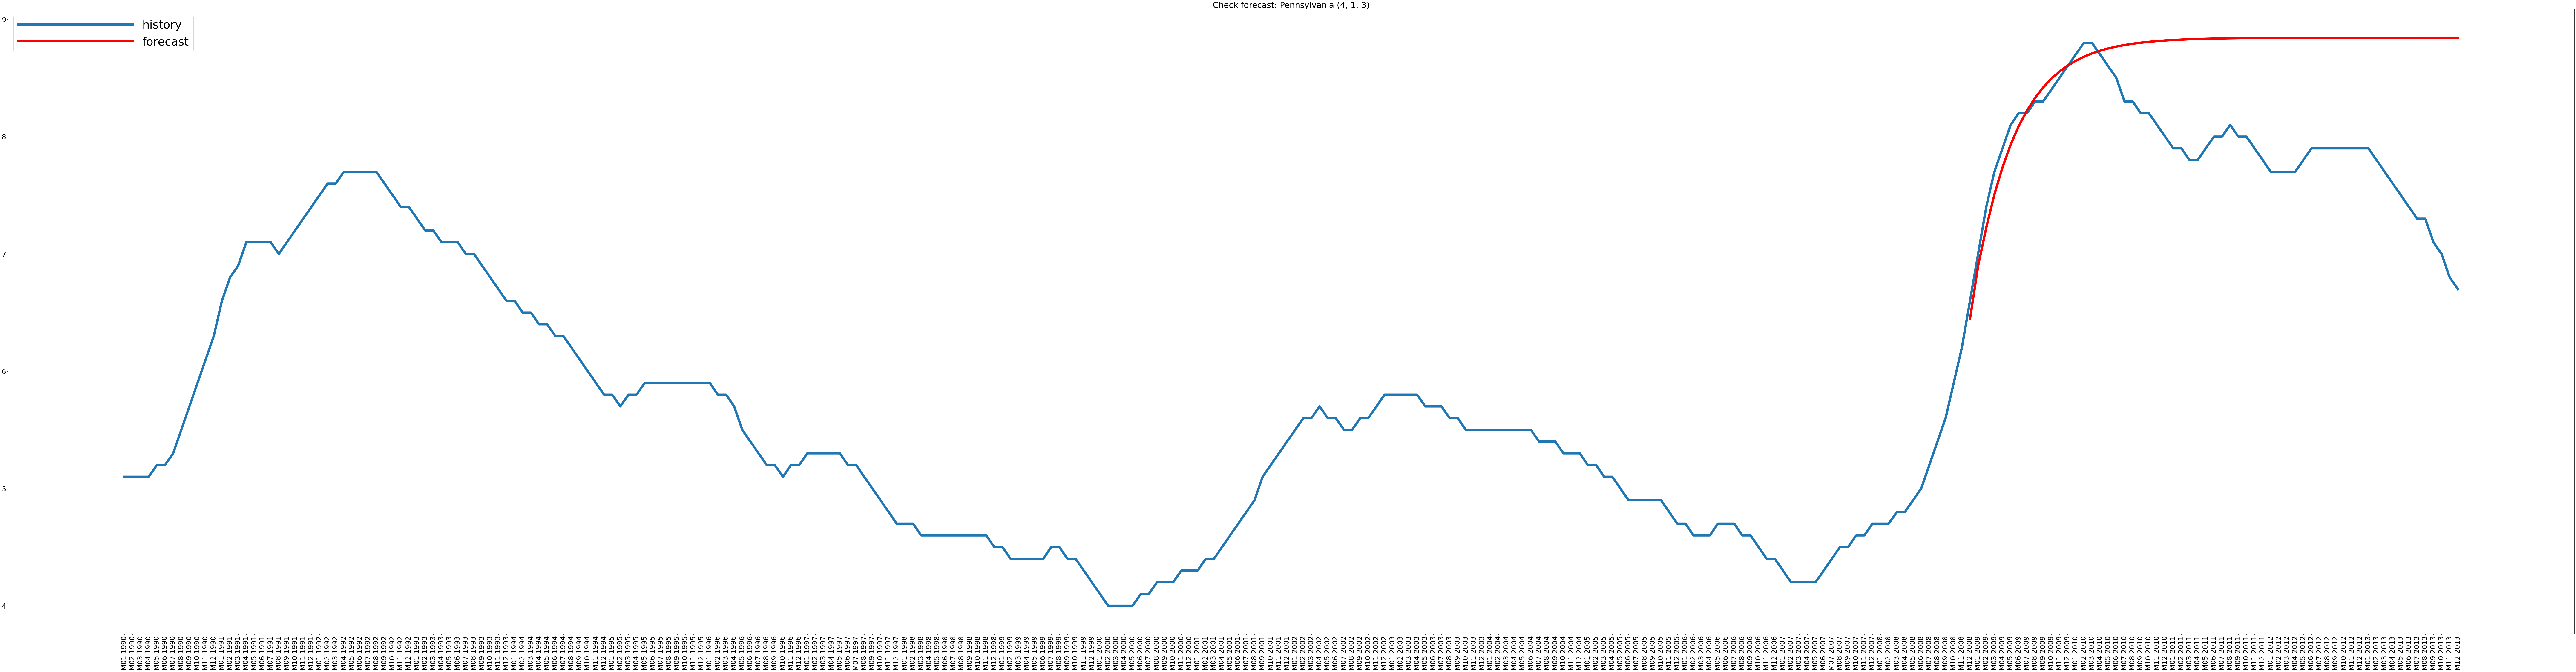


[3] ARIMA(2, 0, 3) 	 Validation MSE=0.004 	 Test MSE=0.023
Maximum unemployment rate 10.51 at M02 2021


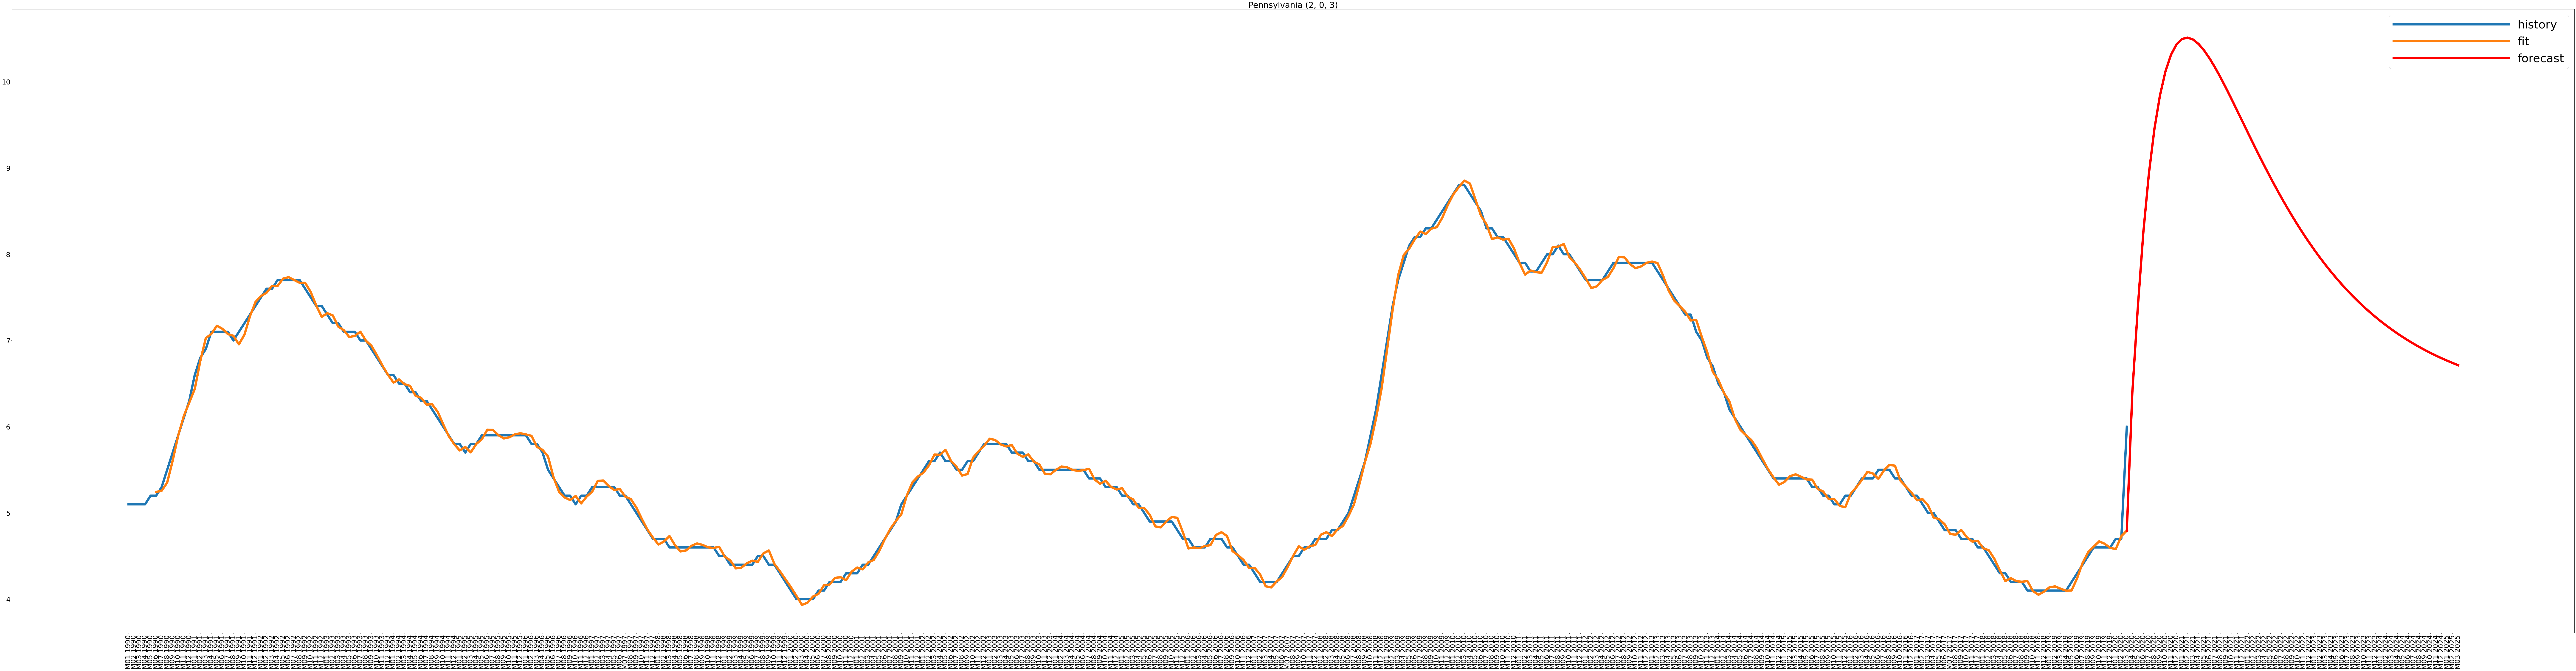

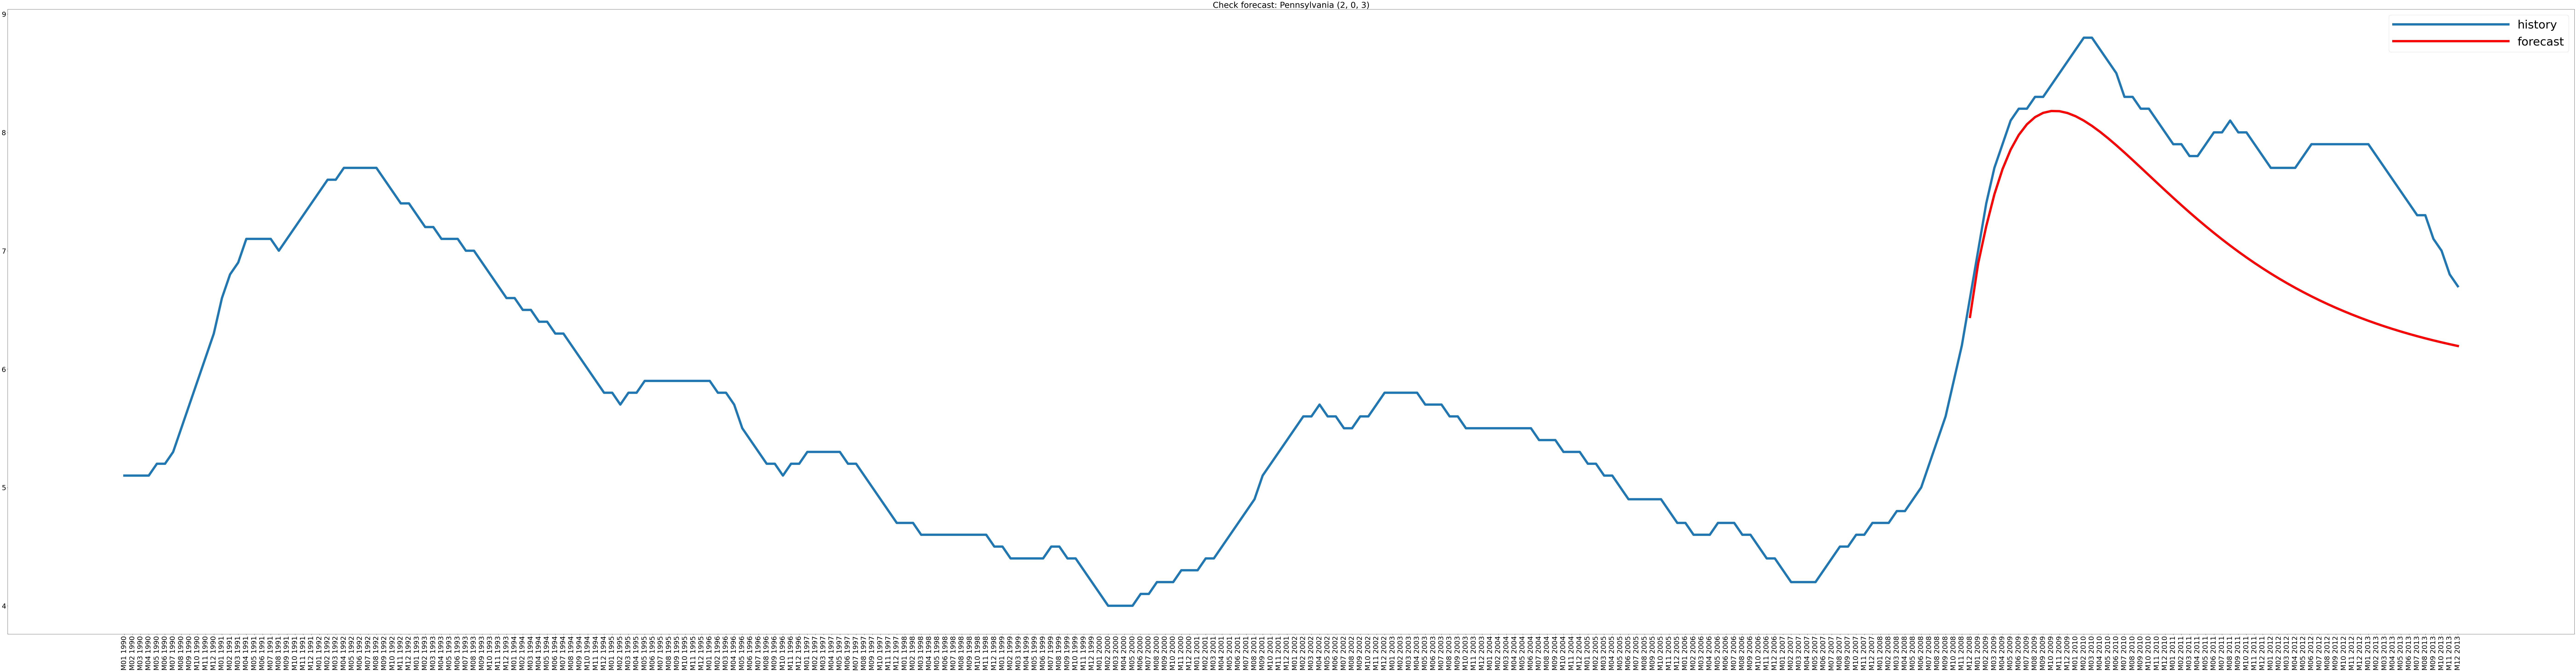

In [0]:
penn_ts = state_data['Pennsylvania']
penn_results = grid_search(penn_ts)

for i in range(3):
    print('\n[%d] ARIMA%s \t Validation MSE=%.3f \t Test MSE=%.3f' % (i+1, penn_results[i][0], penn_results[i][1][0], penn_results[i][1][1]))
    forecast(penn_ts, 'Pennsylvania', order=penn_results[i][0], future_steps=12*5)
    check_forecast(penn_ts, 'Pennsylvania', list(range(1990,2009)), order=penn_results[i][0], future_steps=12*5)